# Intuition

We are provided with the information that a certain interval $0\leq t_1 < t_2 \leq T$ is corrupted in terms of the covariance structure of the data. This implies that there are *two* distinct points of regime change exactly at $t_1$ and $t_2$: from the regular state to corrupted state at $t_1$, and back to the regular state from the corrupted state at $t_2$.

In the context of principal component analysis, consider that when the data feed enters corrupted state at $t_1$, certain covariance metric of the first few principal components should change in a drastic fashion. In the same logic, the reversed metric time series from $T$ to $t_2$, should as well experience such drastic change from the final regular state to the previous corrupted state.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

def pca_power(matrix, n, max_iter=1000, tolerance=1e-10):
    it = 0
    oldnormw = 0.
    v = np.random.random(n)
    w = np.zeros(n)
    
    while it < max_iter:
        w = matrix.dot(v)
        normw = (np.inner(w,w))**.5
        v = w/normw
        if np.abs(normw - oldnormw)/normw < tolerance:
            break
        oldnormw = normw
        it += 1
    return normw, v

def pca_power_full(matrix, n, max_iter=1000, tolerance=1e-10, n_components=10):
    vals = np.zeros(n_components)
    vecs = np.zeros((n_components, n))
    for i in range(n_components):
        val, vec = pca_power(matrix, n, max_iter, tolerance)
        matrix -= val * np.outer(vec, vec)
        vals[i] = val
        np.copyto(vecs[i], vec)
    return vals, vecs   

def read_data(data_dir:str = "../hw3/", filename="polluteddeltas.csv") -> np.ndarray:
    filename = data_dir + filename
    f = open(filename,'r')
    csvf = csv.reader(f)
    polluteddeltalist = list(csvf)
    f.close() 
    plist = np.array(polluteddeltalist)
    polluteddata = plist.astype(float) 
    return polluteddata

In [2]:
d = read_data()[:,1:]
d.shape

(1709, 30)

# Heuristics: First principal component could explain most of the variation.
The curve for the variance explanied by the each principal component: it decays very fast after the first one. 

Explained variance ratio:
[8.33667549e-01 8.27616090e-02 2.69956589e-02 1.50888785e-02
 9.53845342e-03 6.44772351e-03 4.75713392e-03 3.86143962e-03
 2.83758326e-03 1.88153622e-03 1.56894934e-03 1.38314769e-03
 1.19946798e-03 9.61661007e-04 8.42107504e-04 7.90898497e-04
 7.28218084e-04 5.90822047e-04 5.44982339e-04 5.07637406e-04
 4.60027936e-04 4.40135097e-04 3.89222687e-04 3.56094758e-04
 3.37163409e-04 3.07189516e-04 2.90735606e-04 2.38327797e-04
 2.25645554e-04 1.57488323e-13]

Leading eigenvalue:
2279.659932350451


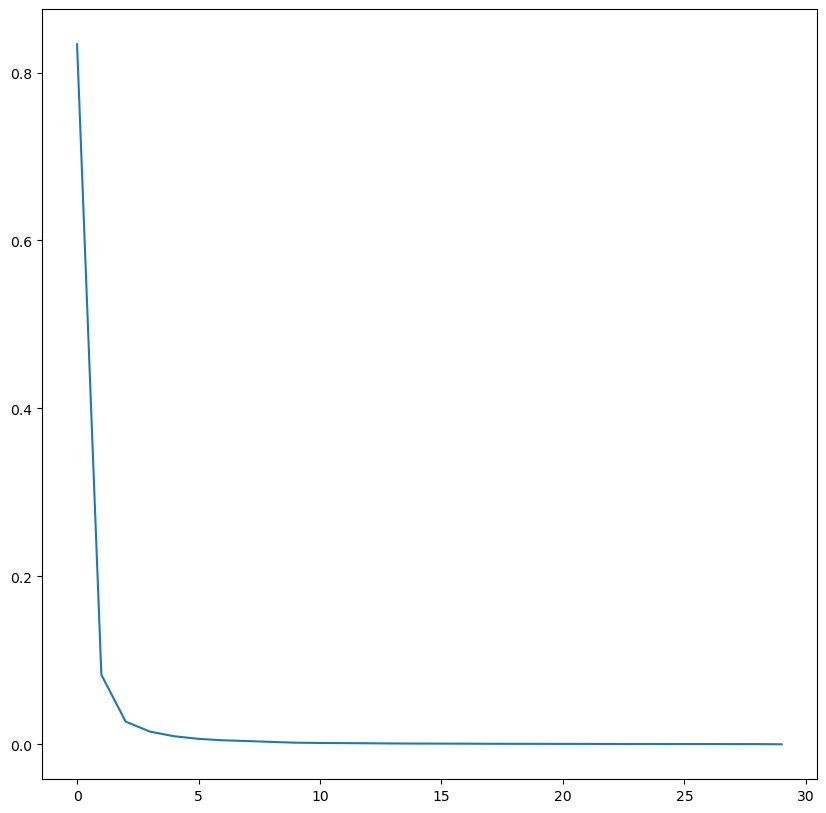

In [3]:
cov = np.cov(d[:200].T)
vals, vecs = pca_power_full(cov, d.shape[1], n_components=30)

print("Explained variance ratio:")
evr = vals / vals.sum()
print(evr)
print()
print("Leading eigenvalue:")
eig1 = vals[0]
print(eig1)
fig, ax = plt.subplots(1,1,figsize = [10, 10])
ax.plot(evr)

In [4]:
n_components = 1
T, k = d.shape
w = 500 # rolling window size
dt = 1

eigs = np.zeros((T, n_components))
evrs = np.zeros((T, n_components))
vecs = np.zeros((T, k))

for t in range(0, T-w, dt):
    cov = np.cov(d[t:t+w].T)
    eigs[t], vecs[t] = pca_power_full(cov, k, n_components=n_components)

# We use the following 2 metrics: inner product and L2 norm, to compare the leading eigenvectors. 

## Leading Eigenvector Inner Product Tracer

### find an appropriate benchmark period, referred as "key"
We check the plot for absolute value of inner products between leading eigenvector of [key, key+w] and all rolling windows with length w
- If the chosen period "key" is regular, then the absolute inner product should be close to 1 for regular periods, and significantly deviate from 1 for corrupted periods. So the plot should be very close to 1 at the beginning and near the end, but significantly smaller than 1 during [$t_1, t_2$]
- If the chosen period "key" is corrupted, then the absolute inner product should be close to 1 for other corrupted periods, and significantly deviate from 1 for regular periods. So the plot should be smaller than 1 at the beginning and near the end, and very close to 1 in the middle. 

Therefore, we can conclude from the 2 plots below that it's safe to choose "key" period from the first 200 periods as benchmark, since they are regular. 

In [5]:
def plot_keys_innerprods(regular_key, corrupt_key):
    # inner prod tracer with 
    regular_innerprods = np.zeros(T-w)
    for i in range(0, T-w, dt):
        regular_innerprods[i] = np.abs(
            np.inner(vecs[regular_key], vecs[i])
        )
    corrupt_innerprods = np.zeros(T-w)
    for i in range(0, T-w, dt):
        corrupt_innerprods[i] = np.abs(
            np.inner(vecs[corrupt_key], vecs[i])
        )

    fig, ax = plt.subplots(2, 2, figsize=[20, 10], sharex=True)
    ax[0,0].plot(np.arange(w, T, dt), eigs[eigs!=0])
    ax[0,0].set_title(f"Leading Eigenvalues with key = {regular_key}")
    ax[1,0].plot(np.arange(w, T, dt), regular_innerprods)    
    ax[1,0].set_title(f"Inner Products with key = {regular_key}")

    ax[0,1].plot(np.arange(w, T, dt), eigs[eigs!=0])
    ax[0,1].set_title(f"Leading Eigenvalues with key = {corrupt_key}")
    ax[1,1].plot(np.arange(w, T, dt), corrupt_innerprods)    
    ax[1,1].set_title(f"Inner Products with key = {corrupt_key}")

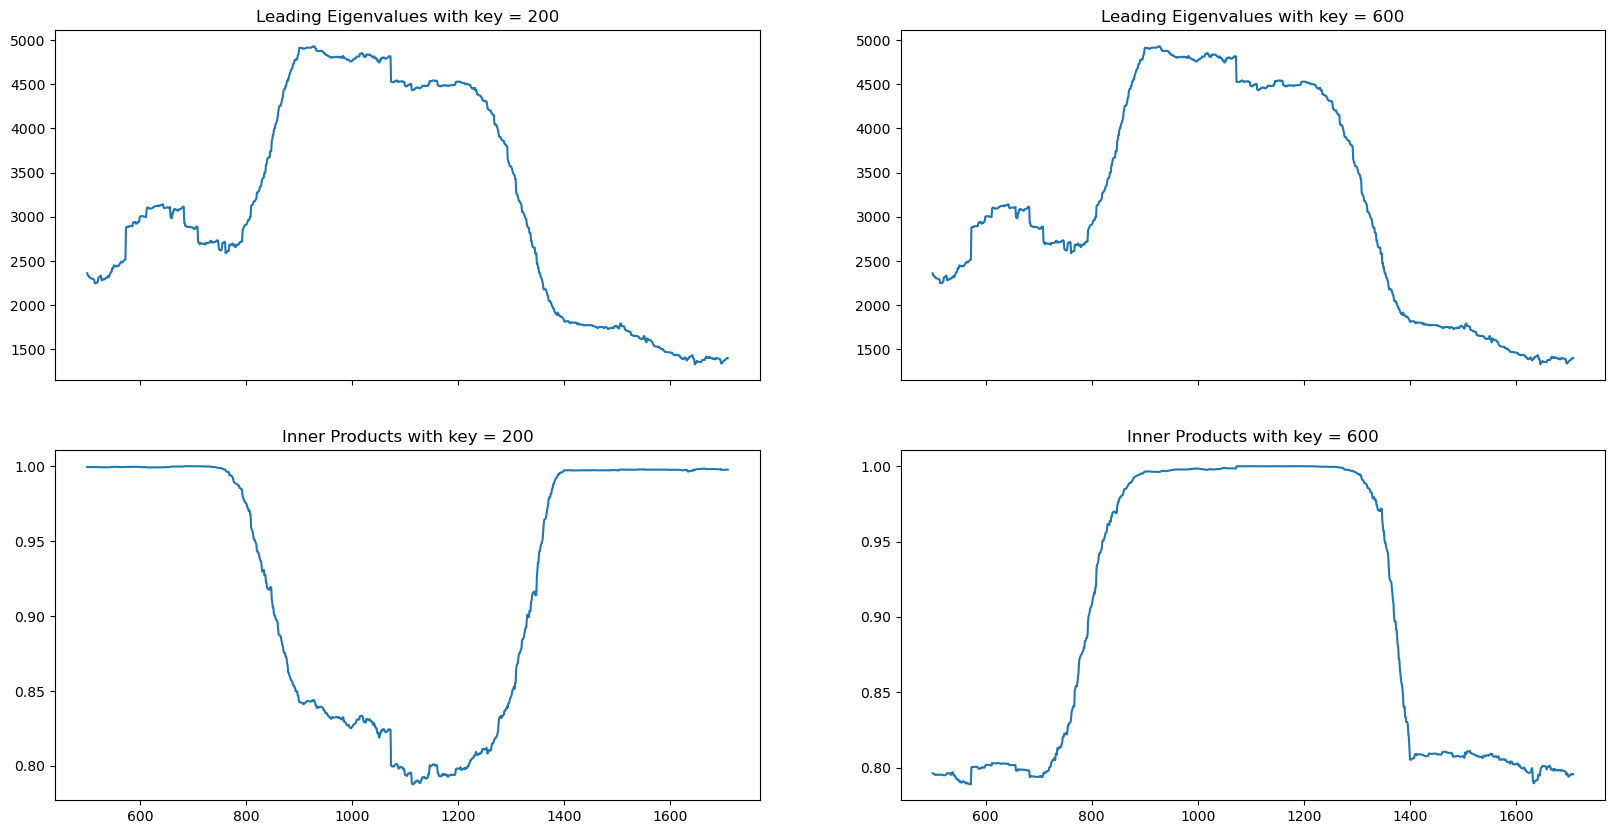

In [6]:
plot_keys_innerprods(200, 600)

### Use distribution rule to determine first occurrence of corruption:

For regular periods, the inner products should be very close to 1. We define threshold to identify outlier by the mean and standard deviation from the first and lat 100 periods. 

In [7]:
key = 141

innerprods = np.zeros(T-w)
for i in range(0, T-w, dt):
    innerprods[i] = np.abs(
        np.inner(vecs[key], vecs[i])
    )

# forward and backward reference
baseline_1 = innerprods[:100]
baseline_2 = innerprods[-100:]
k = 5

# forward and backward first occurrence
thresh_1 = baseline_1.mean() - k * baseline_1.std()
thresh_2 = baseline_2.mean() - k * baseline_2.std()
print("t1:", (innerprods < thresh_1).argmax() + w)
print("t2:", T - ((innerprods[::-1] < thresh_2).argmax() + w))

t1: 761
t2: 883


In [8]:
N = 200
result_innerprod = np.zeros((N, 2))

for key in range(N):

    innerprods = np.zeros(T-w)
    for i in range(0, T-w, dt):
        innerprods[i] = np.abs(
            np.inner(vecs[key], vecs[i])
        )

    baseline_1 = innerprods[:100]
    baseline_2 = innerprods[-100:]
    k = 5

    # forward and backward first occurrence
    thresh_1 = baseline_1.mean() - k * baseline_1.std()
    thresh_2 = baseline_2.mean() - k * baseline_2.std()
    t1 = (innerprods < thresh_1).argmax() + w
    t2 = T - ((innerprods[::-1] < thresh_2).argmax() + w)

    result_innerprod[key] = t1, t2

### Period [$t_1$, $t_2$] as determined using inner product method:

In [9]:
period_innerprod = result_innerprod.mean(axis = 0).astype(int)
print("t1:", period_innerprod[0])
print("t2:", period_innerprod[1])

t1: 749
t2: 888


## Leading Eigenvector L2 Norm Tracer

### find an appropriate benchmark period, referred as "key"
We check the plot for the l2 norm of the difference between leading eigenvector of [key, key+w] and all rolling windows with length w
- If the chosen period "key" is regular, then the l2 norm of difference should be close to 0 for regular periods, and significantly deviate from 0 for corrupted periods. So the plot should be very close to 0 at the beginning and near the end, but significantly larger than 0 during [$t_1, t_2$]
- If the chosen period "key" is corrupted, then the l2 norm of difference should be close to 0 for other corrupted periods, and significantly deviate from 0 for regular periods. So the plot should be larger than 0 at the beginning and near the end, and very close to 0 in the middle. 

Therefore, we can reach the same conclusion as before using inner product: it's safe to choose "key" period from the first 200 periods as benchmark, since they are regular. 

In [10]:
def plot_keys_l2(regular_key, corrupt_key):
    # inner prod tracer with 
    regular_l2 = (np.sqrt((vecs - vecs[regular_key])**2)).sum(axis = 1)[:T-w]
    corrupt_l2 = (np.sqrt((vecs - vecs[corrupt_key])**2)).sum(axis = 1)[:T-w]

    fig, ax = plt.subplots(2, 2, figsize=[20, 10], sharex=True)
    ax[0,0].plot(np.arange(w, T, dt), eigs[eigs!=0])
    ax[0,0].set_title(f"Leading Eigenvalues with key = {regular_key}")
    ax[1,0].plot(np.arange(w, T, dt), regular_l2)    
    ax[1,0].set_title(f"L2 Norms with key = {regular_key}")

    ax[0,1].plot(np.arange(w, T, dt), eigs[eigs!=0])
    ax[0,1].set_title(f"Leading Eigenvalues with key = {corrupt_key}")
    ax[1,1].plot(np.arange(w, T, dt), corrupt_l2)    
    ax[1,1].set_title(f"L2 Norms with key = {corrupt_key}")

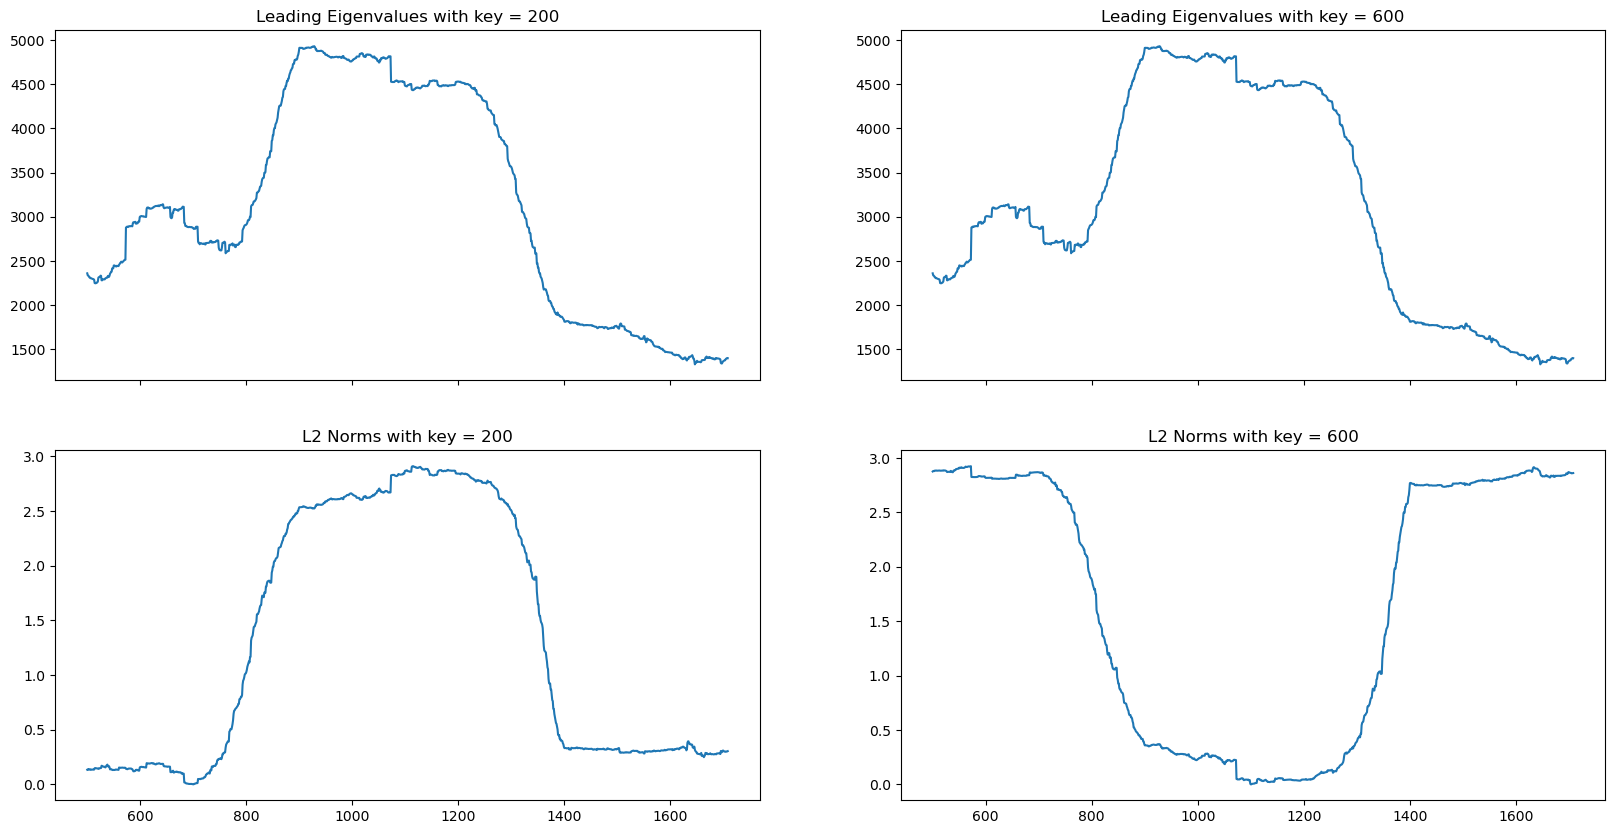

In [11]:
plot_keys_l2(200, 600)

### Use distribution rule to determine first occurrence of outlier

Usually, the L2 norm should be around 0. When the metric drifts away from 0, we say that the data feed has entered the corrupted state.

In [12]:
key = 141

l2 = (np.sqrt((vecs - vecs[key])**2)).sum(axis = 1)[:T-w]

# forward and backward reference
baseline_1 = l2[:100]
baseline_2 = l2[-100:]
k = 5

# forward and backward first occurrence
thresh_1 = baseline_1.mean() + k * baseline_1.std()
thresh_2 = baseline_2.mean() + k * baseline_2.std()
print("t1:", (l2 > thresh_1).argmax() + w)
print("t2:", T - ((l2[::-1] > thresh_2).argmax() + w))

t1: 768
t2: 881


In [17]:
N = 200
result_l2 = np.zeros((N, 2))

for key in range(N):

    l2 = (np.sqrt((vecs - vecs[key])**2)).sum(axis = 1)[:T-w]

    baseline_1 = l2[:100]
    baseline_2 = l2[-100:]
    k = 5

    # forward and backward first occurrence
    thresh_1 = baseline_1.mean() + k * baseline_1.std()
    thresh_2 = baseline_2.mean() + k * baseline_2.std()
    t1 = (l2 > thresh_1).argmax() + w
    t2 = T - ((l2[::-1] > thresh_2).argmax()+w)

    result_l2[key] = t1, t2

### Period [$t_1$, $t_2$] as determined using L2 Norm method:

In [16]:
period_l2 = result_l2.mean(axis = 0).astype(int)
print("t1:", period_l2[0])
print("t2:", period_l2[1])

t1: 755
t2: 887
